In [139]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [140]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
# data = np.array(data)
# labels = np.array(labels)


## Data Preparation

### Define Preprocessing Function


In [141]:
def resize(img, target_height, target_width):
    height, width = img.shape
    resized_img = np.zeros((target_height, target_width), dtype=np.uint8)
    
    scale_x = width / target_width
    scale_y = height / target_height

    for i in range(target_height):
        for j in range(target_width):
            orig_x = min(int(j * scale_x), width - 1)
            orig_y = min(int(i * scale_y), height - 1)
            resized_img[i, j] = img[orig_y, orig_x]

    return resized_img

def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalized_img = (img - min_val) / (max_val - min_val) * 255
    return normalized_img.astype(np.uint8)


def percobaan_1(img, target_height, target_width):
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    resized_img = resize(gray_img, target_height, target_width)
    normalize_img = normalize(resized_img)
    return normalize_img


### Preprocessing

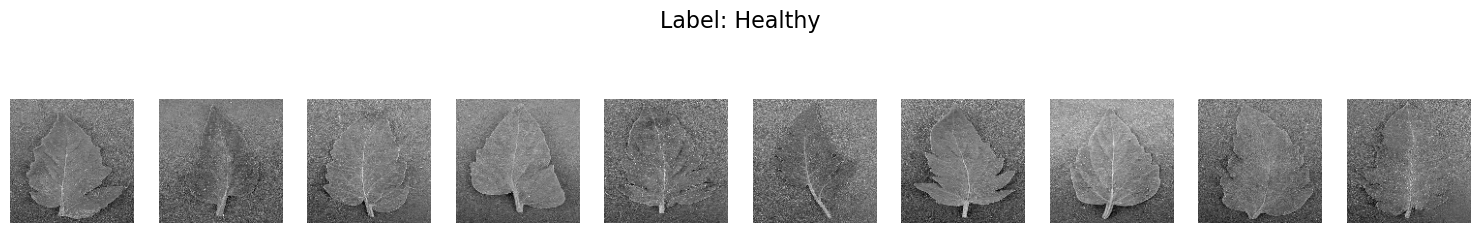

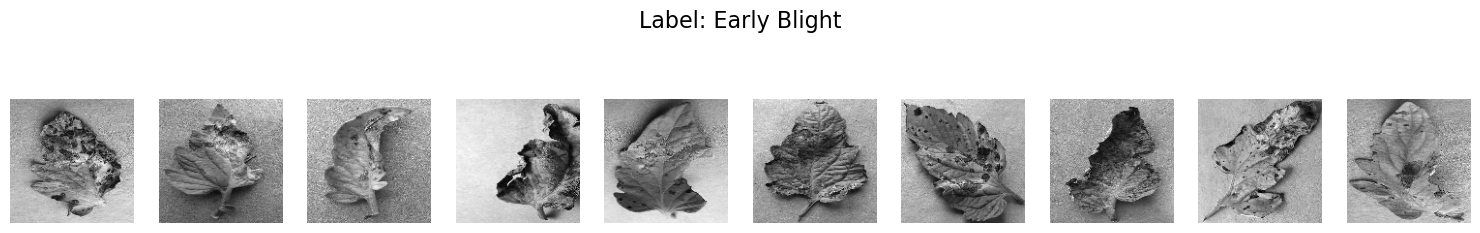

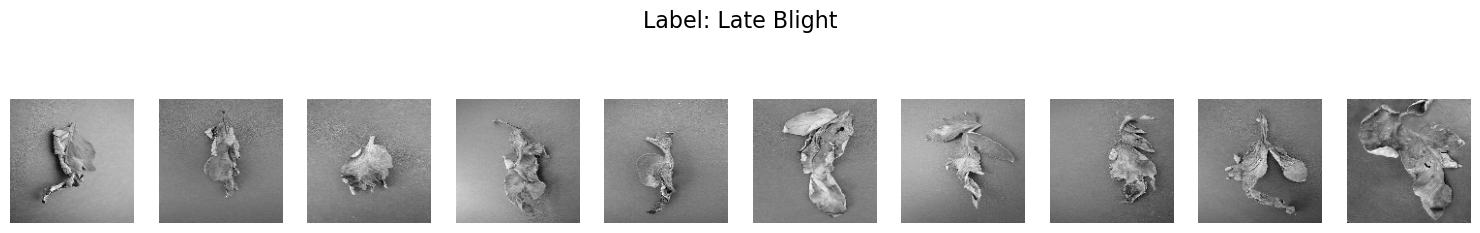

In [142]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = [percobaan_1(img, 128, 128) for img in data]
dataPreprocessed = np.array(dataPreprocessed)
labels = np.array(labels)

label_names = {
    "Label 1": "Healthy",
    "Label 2": "Early Blight",
    "Label 3": "Late Blight"
}

# Loop untuk setiap label
for label_code in label_names:
    # Ambil 100 index pertama dengan label ini
    idxs = np.where(labels == label_code)[0][:10]

    # Buat figure
    plt.figure(figsize=(15, 15))
    plt.suptitle(f"Label: {label_names[label_code]}", fontsize=16)

    for i, idx in enumerate(idxs):
        plt.subplot(10, 10, i + 1)
        plt.imshow(dataPreprocessed[idx], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


### Feature Extraction

In [143]:
def glcm(image, derajat):
    image = (image * 255).astype(np.uint8)  
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [144]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [145]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [146]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [147]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [148]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [149]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [150]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [151]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [152]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [153]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [154]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [155]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [156]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [157]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [158]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [159]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [160]:
# Gabungkan semua fitur dari setiap citra ke dalam satu array fitur per gambar
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        correlation0[i], correlation45[i], correlation90[i], correlation135[i],
        dissimilarity0[i], dissimilarity45[i], dissimilarity90[i], dissimilarity135[i],
        Kontras0[i], Kontras45[i], Kontras90[i], Kontras135[i],
        homogenity0[i], homogenity45[i], homogenity90[i], homogenity135[i],
        entropy0[i], entropy45[i], entropy90[i], entropy135[i],
        ASM0[i], ASM45[i], ASM90[i], ASM135[i],
        energy0[i], energy45[i], energy90[i], energy135[i],
    ]
    features.append(fitur)

# Ubah menjadi numpy array agar bisa digunakan di ML model
features = np.array(features)
labels = np.array(labels)


### Write the extraction's results to CSV 

In [161]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,c1c04a55-0dd5-48e2-9cc6-76bbcc1899fd___GH_HL L...,Label 1,646.129245,672.982082,647.465244,653.440325,0.065801,0.061459,0.061611,0.063010,...,0.000326,0.000325,0.018172,0.018007,0.018051,0.018021,0.489339,0.464350,0.485378,0.479814
1,c1dfd66e-7c0c-40a7-8280-0aa1aaf5436b___GH_HL L...,Label 1,738.006582,757.266973,722.803396,747.224688,0.056035,0.055790,0.057675,0.058330,...,0.000302,0.000296,0.017374,0.017301,0.017372,0.017209,0.404128,0.388289,0.415877,0.396416
2,c2c1758f-3576-4e8a-9853-5f11ac4d20d6___GH_HL L...,Label 1,736.876722,763.212226,722.406004,770.582615,0.059695,0.053884,0.053230,0.055819,...,0.000240,0.000240,0.015528,0.015381,0.015477,0.015503,0.527179,0.507325,0.533345,0.502601
3,c6acee22-6c56-41a8-ae90-26c6064e0261___GH_HL L...,Label 1,393.775344,421.470457,390.734560,430.723355,0.076384,0.072036,0.072621,0.074600,...,0.000367,0.000368,0.019399,0.019140,0.019169,0.019181,0.709938,0.687424,0.709947,0.680585
4,c7cedd2f-dfae-4232-9cab-d75197d48948___GH_HL L...,Label 1,974.835076,1005.679893,974.205709,996.832228,0.049492,0.047511,0.050516,0.050975,...,0.000251,0.000249,0.015808,0.015676,0.015851,0.015780,0.297642,0.272298,0.295898,0.278789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,img.JPG,Label 3,243.393639,278.804328,207.520915,264.302375,0.216902,0.174932,0.181742,0.175290,...,0.001341,0.001309,0.039294,0.036174,0.036618,0.036185,0.572510,0.510821,0.634062,0.536282
296,img2.JPG,Label 3,219.787032,271.486143,231.927904,277.663401,0.151626,0.126488,0.140578,0.127926,...,0.001152,0.001073,0.035054,0.032699,0.033943,0.032764,0.774325,0.721912,0.761806,0.715577
297,img3.JPG,Label 3,391.062315,511.492653,419.740465,485.760866,0.148687,0.131391,0.130138,0.126407,...,0.000571,0.000552,0.024794,0.023656,0.023898,0.023491,0.756939,0.682116,0.738960,0.698153
298,img4.JPG,Label 3,346.762549,394.360531,334.994771,482.482671,0.191324,0.150972,0.158689,0.156634,...,0.001865,0.001795,0.046102,0.042322,0.043190,0.042372,0.747500,0.714764,0.756020,0.651032


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

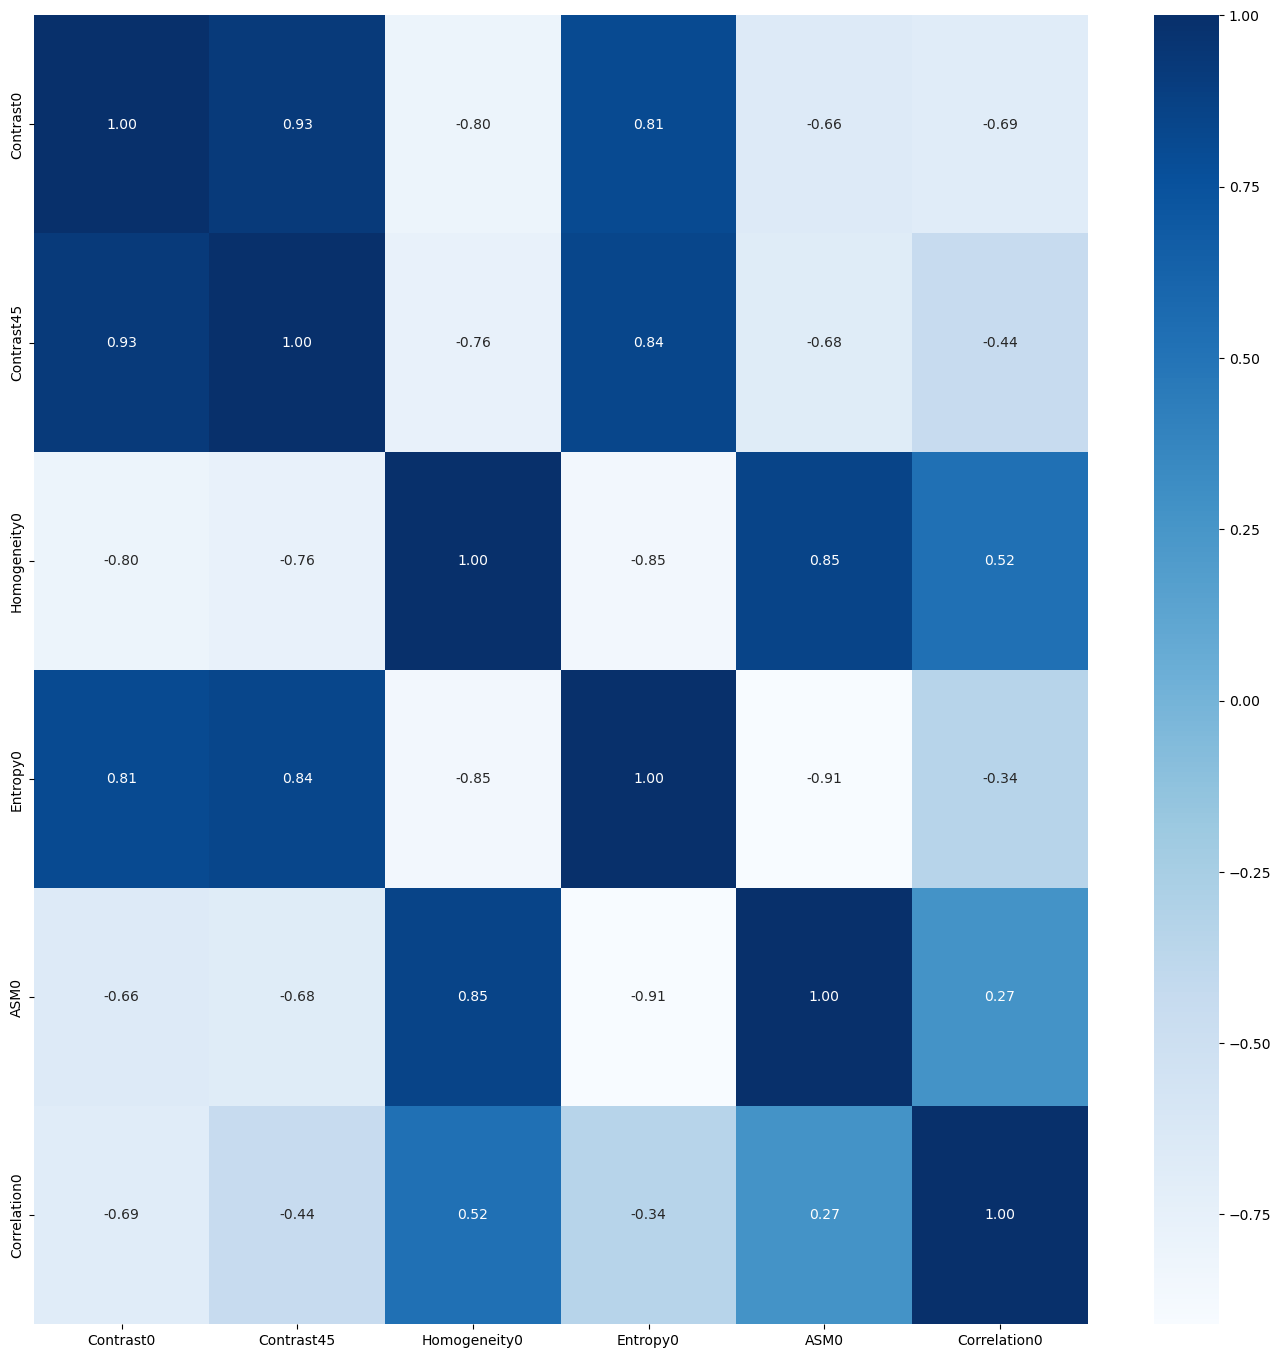

In [162]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

#### Method ANOVA

<Axes: >

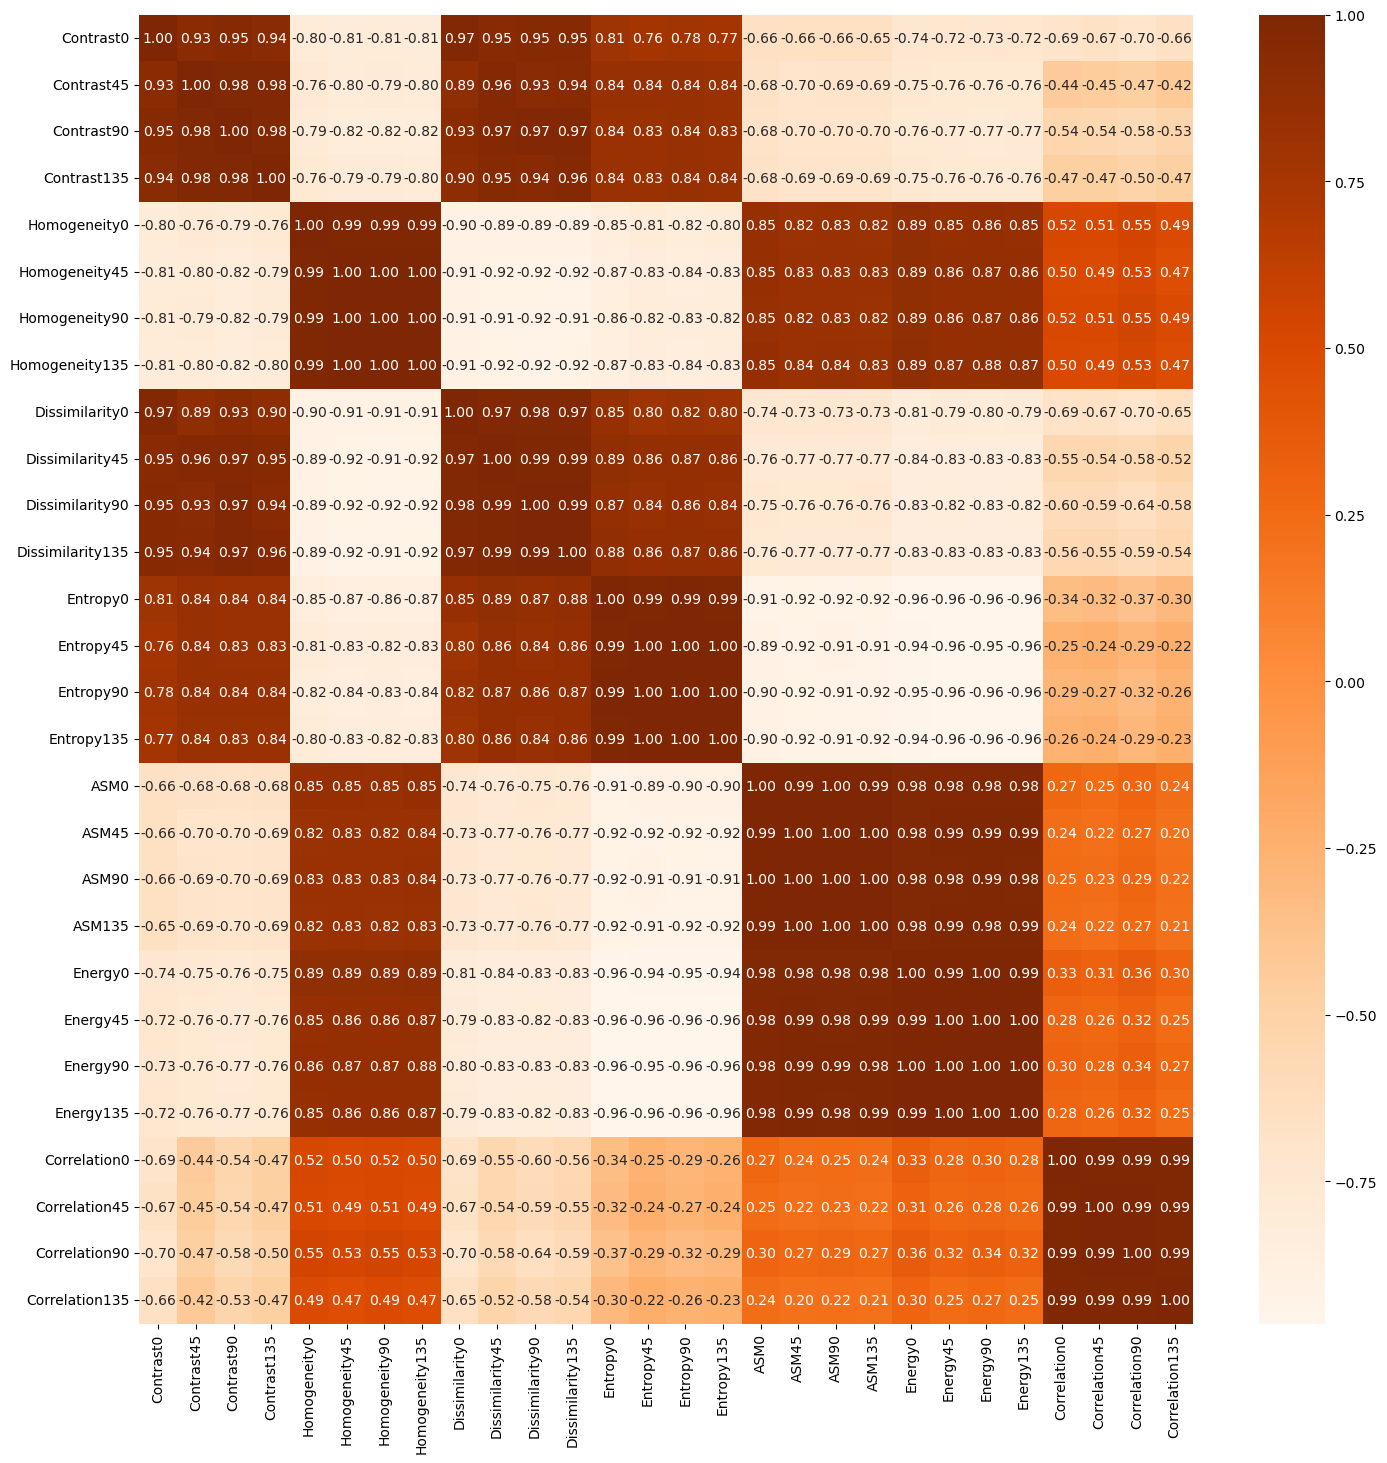

In [163]:
X = hasilEkstrak.drop(columns=['Label', 'Filename'])
y = hasilEkstrak['Label']

# Hitung nilai ANOVA F-score untuk setiap fitur
anova_selector = SelectKBest(score_func=f_classif, k='all')  # 'all' agar kita dapat semua skor
anova_selector.fit(X, y)

# Ambil skor dan nama fitur
anova_scores = anova_selector.scores_
feature_names = X.columns

# Threshold manual (contoh: hanya ambil fitur dengan skor > 5)
threshold = 5
selected_features = feature_names[anova_scores > threshold]

# Tampilkan fitur yang lolos seleksi
x_new = X[selected_features]
x_new

plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Oranges', fmt=".2f")


## Splitting Data

In [164]:
# Memisahkan data menjadi data latih dan data uji
# test_size=0.2 artinya 20% data untuk pengujian, 80% untuk pelatihan
# random_state untuk memastikan hasil konsisten setiap kali dijalankan
# stratify=y memastikan distribusi label tetap seimbang antara train dan test
X_train, X_test, y_train, y_test = train_test_split(
    x_new, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)


print("Data Latih:", X_train.shape)
print("Data Uji:", X_test.shape)


Data Latih: (240, 28)
Data Uji: (60, 28)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [165]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

### Min-Max Scaling

In [166]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modeling

### Define Model

In [167]:
def generateClassificationReport(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("Accuracy:", accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [168]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred_train = rf.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = rf.predict(X_test)
generateClassificationReport( y_test, y_pred_test)

------Training Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.99      1.00      0.99        80
     Label 2       0.99      0.99      0.99        80
     Label 3       0.99      0.97      0.98        80

    accuracy                           0.99       240
   macro avg       0.99      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240

Confusion Matrix:
[[80  0  0]
 [ 0 79  1]
 [ 1  1 78]]
Accuracy: 0.9875

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.87      1.00      0.93        20
     Label 2       1.00      0.95      0.97        20
     Label 3       1.00      0.90      0.95        20

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60

Confusion Matrix:
[[20  0  0]
 [ 1 19  0]
 [ 2  0 18]]
Accuracy: 0.95


### Train SVM Classifier

In [169]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred_train = svm.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = svm.predict(X_test)
generateClassificationReport( y_test, y_pred_test)


------Training Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.97      0.95      0.96        80
     Label 2       0.90      0.99      0.94        80
     Label 3       0.97      0.90      0.94        80

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240

Confusion Matrix:
[[76  2  2]
 [ 1 79  0]
 [ 1  7 72]]
Accuracy: 0.9458333333333333

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.90      0.90      0.90        20
     Label 2       0.91      1.00      0.95        20
     Label 3       1.00      0.90      0.95        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

Confusion Matrix:
[[18  2  0]
 [ 0 20  0]
 [ 2  0 18]]
Ac

### Train KNN Classifier

In [170]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred_train = knn.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = knn.predict(X_test)
generateClassificationReport( y_test, y_pred_test)



------Training Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.94      0.96      0.95        80
     Label 2       0.97      0.96      0.97        80
     Label 3       0.95      0.94      0.94        80

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240

Confusion Matrix:
[[77  1  2]
 [ 1 77  2]
 [ 4  1 75]]
Accuracy: 0.9541666666666667

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.91      1.00      0.95        20
     Label 2       1.00      1.00      1.00        20
     Label 3       1.00      0.90      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

Confusion Matrix:
[[20  0  0]
 [ 0 20  0]
 [ 2  0 18]]
Ac

## Evaluation With Confusion Matrix

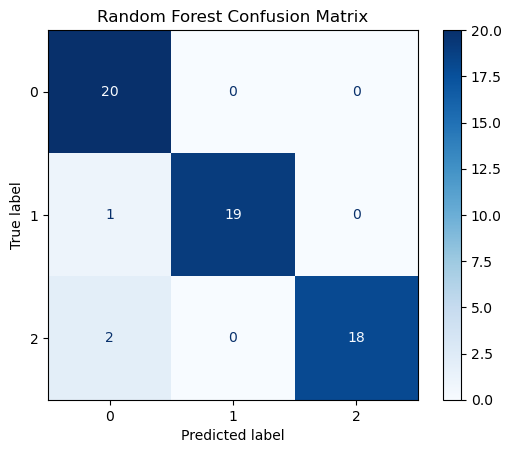

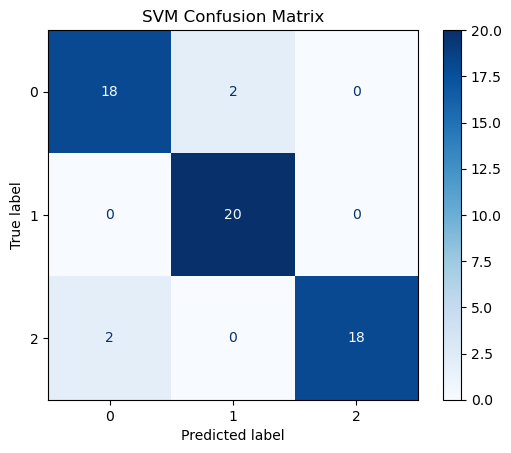

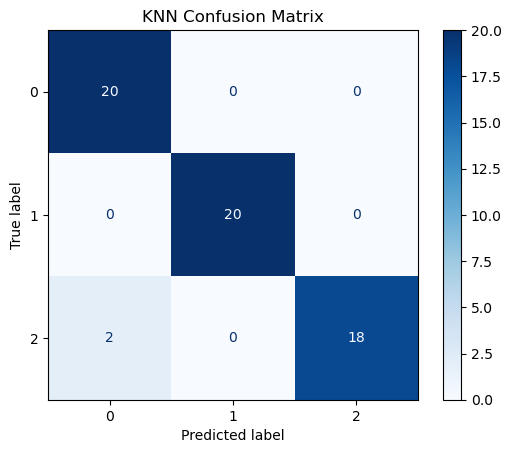

In [171]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")